# Bike Sharing Demand
## Michał Binda, Mikołaj Mróz, Paweł Swiderski

In [137]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pylab
import calendar
import seaborn as sn
from scipy import stats
# import missingno as msno
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [92]:
df_train = pd.read_csv('train.csv',header = 0)
df_test = pd.read_csv('test.csv', header = 0)

### We are to predict the count column so we will separate it from the train dataframe

### Functions

In [93]:
def modify_datetime(df):

    # We will simply extract year, month, day, weekday, and hour from the datetime feature
    df['year'] = pd.DatetimeIndex(df.datetime).year
    df['month'] = pd.DatetimeIndex(df.datetime).month
    df['day'] = pd.DatetimeIndex(df.datetime).day
    df['weekday'] = pd.DatetimeIndex(df.datetime).dayofweek
    df['hour'] = pd.DatetimeIndex(df.datetime).hour  
    return df

In [94]:
# def modify_datetime(df):
#     df['month'] = pd.DatetimeIndex(df.datetime).month
#     df['day'] = pd.DatetimeIndex(df.datetime).dayofweek
#     df['hour'] = pd.DatetimeIndex(df.datetime).hour
    
#     return df

In [95]:
def modify_to_category(df):
    categoryVariableList = ["season","weather","holiday","workingday"]
    for var in categoryVariableList:
        df[var] = df[var].astype("category")
    
    return df

## Data exploration

In [101]:
print("Dimensions of dataframe: ", df_train.shape)

Dimensions of dataframe:  (10886, 12)


### Checking NaN Values

In [102]:
nan_values = df_train[df_train.isna().any(axis=1)]
print(nan_values)

Empty DataFrame
Columns: [datetime, season, holiday, workingday, weather, temp, atemp, humidity, windspeed, casual, registered, count]
Index: []


### As we see there is no NaN values in the dataframe

In [103]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


#### **Data Fields**

* datetime - hourly date + timestamp  
* season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather - 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals (Dependent Variable)

### Firstly, we'll check the feature types

In [104]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [105]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


### We see there is no casual and registered column in test frame so we will drop them

In [106]:
df_train = df_train.drop(["casual", "registered"], axis=1)

### We have to deal with datetime, namely convert it from object to something useful.

In [107]:
def modify_datetime(df):

    # We will simply extract year, month, day, weekday, and hour from the datetime feature
    df['year'] = pd.DatetimeIndex(df.datetime).year
    df['month'] = pd.DatetimeIndex(df.datetime).month
    df['day'] = pd.DatetimeIndex(df.datetime).day
    df['weekday'] = pd.DatetimeIndex(df.datetime).dayofweek
    df['hour'] = pd.DatetimeIndex(df.datetime).hour  
    return df

In [108]:
modify_datetime(df_train)
modify_datetime(df_test)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,weekday,hour
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,3,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,1
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,3,2
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,0,19
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,2012,12,31,0,20
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,2012,12,31,0,21
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,2012,12,31,0,22


In [109]:
df_train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,day,weekday,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,2011,1,1,5,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,2011,1,1,5,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2011,1,1,5,2
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,2011,1,1,5,3
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,2011,1,1,5,4


### We can now drop the datetime column

In [111]:
df_train = df_train.drop('datetime', axis=1)
df_test = df_test.drop('datetime', axis=1)

### We will also change to type of season, weather, workingday, and holiday columns to category type as it is more apt

In [112]:
def modify_to_category(df):
    categoryVariableList = ["season","weather","holiday","workingday"]
    for var in categoryVariableList:
        df[var] = df[var].astype("category")
    
    return df

In [113]:
df_train = modify_to_category(df_train)
df_test = modify_to_category(df_test)

### Let's see how the features are distributed

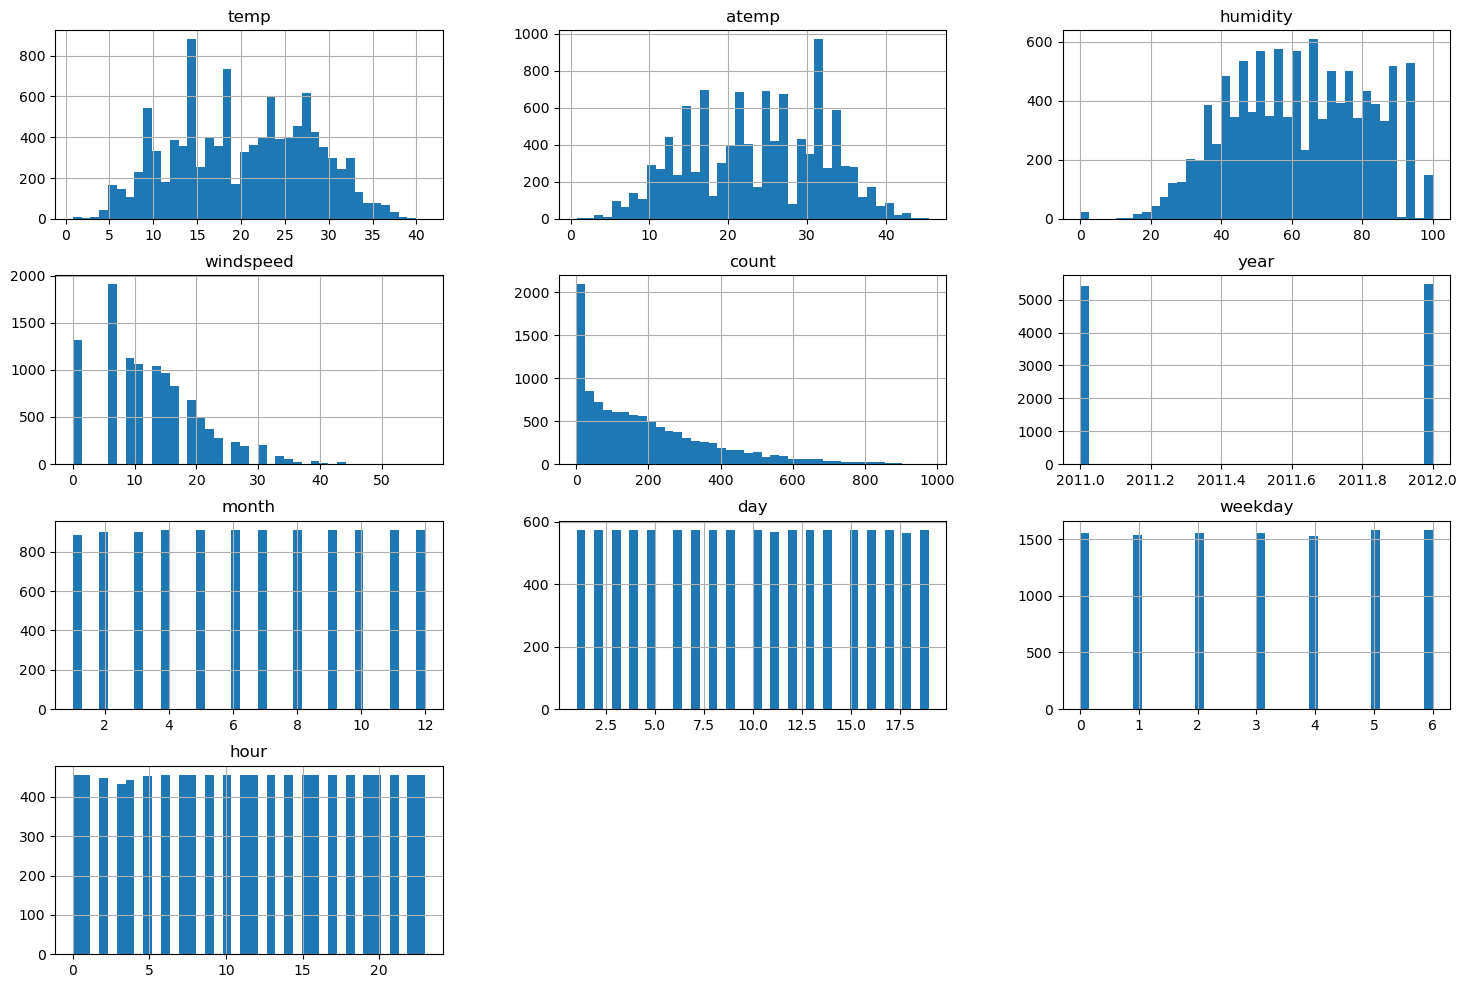

In [114]:
df_train.hist(bins = 40, figsize=(18, 12))

plt.show()

### We can see a strange number of zero values in humidity and windspeed features

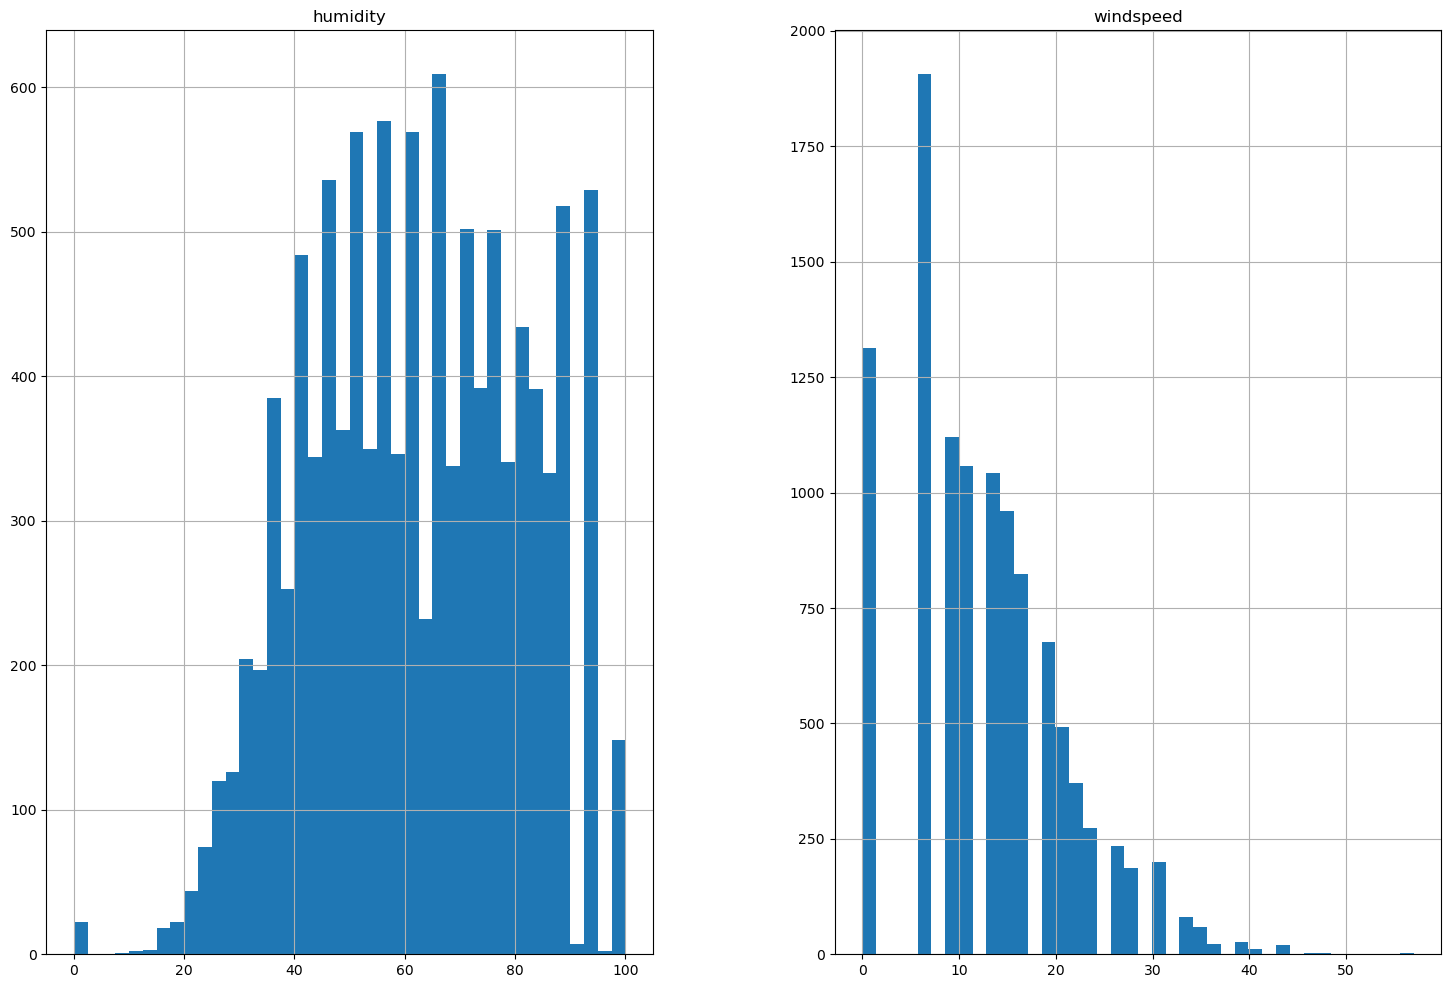

In [115]:
df_train.iloc[:, 6:8].hist(bins = 40, figsize=(18, 12))

plt.show()


In [11]:
print("number of zeros in the humidity column: ", df_train["humidity"].value_counts()[0])
print("number of zeros in the windspeed column: ", df_train["windspeed"].value_counts()[0])

number of zeros in the humidity column:  22
number of zeros in the windspeed column:  1313


### Obviously, the value zero in both of those columns does not make sense in real life, so we should treat is a missing value, hence we are to handle it in some way.

### Let's use KNNImputer tree model to replace missing values in windspeed column.

In [116]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=0)
df_train["windspeed"] = imputer.fit_transform(df_train[["windspeed"]]).ravel()
df_train["humidity"] = imputer.fit_transform(df_train[["humidity"]]).ravel()

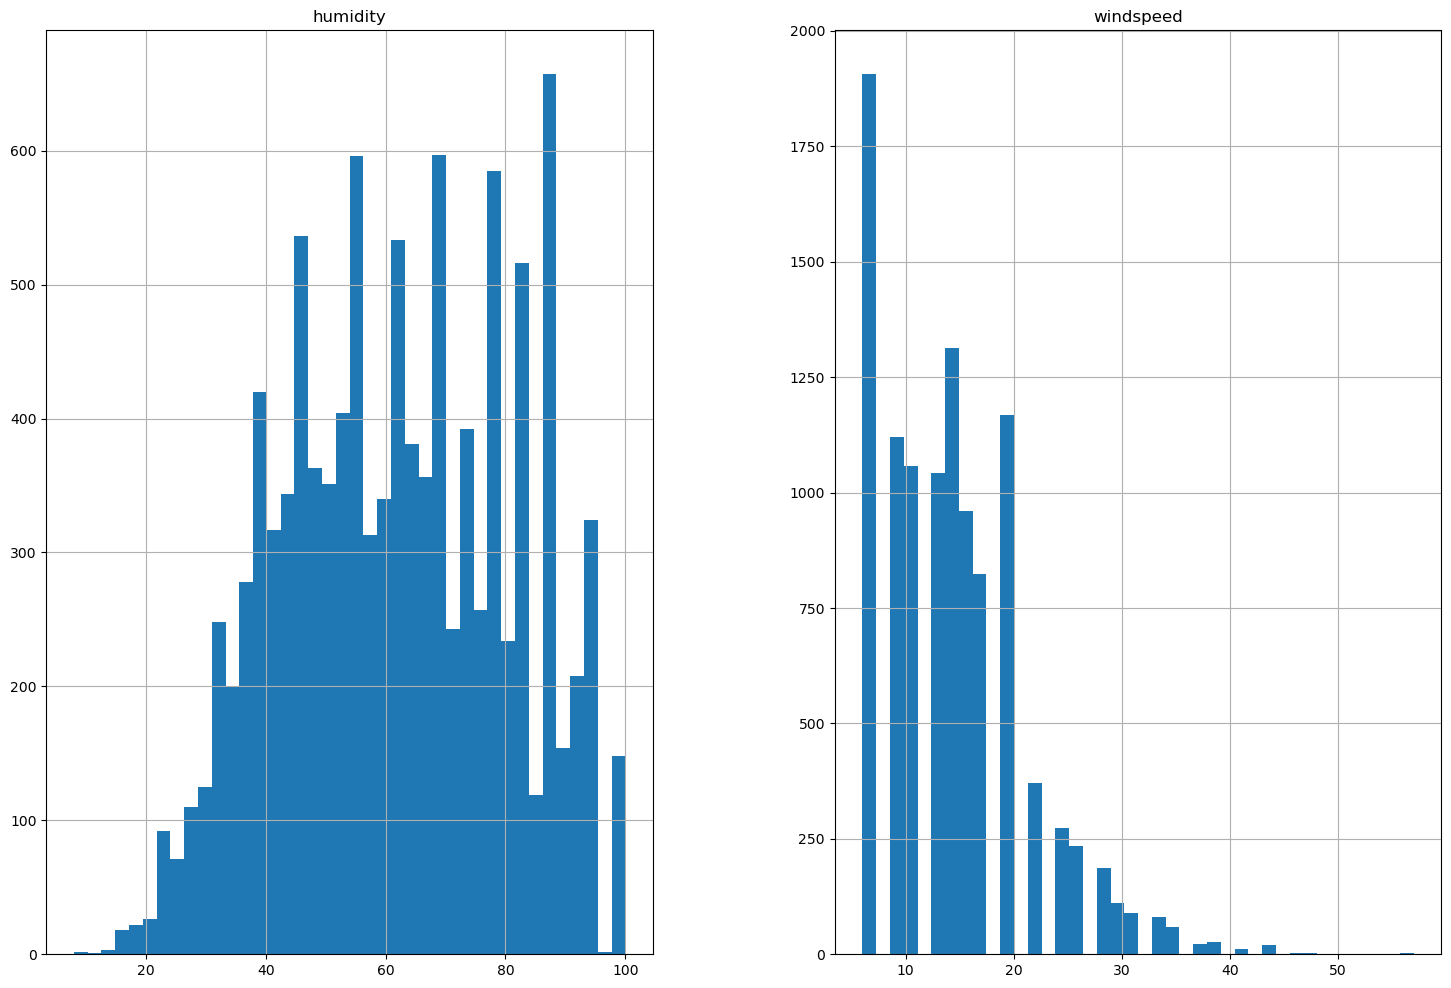

In [117]:
df_train.iloc[:, 6:8].hist(bins = 40, figsize=(18, 12))

plt.show()

In [119]:
for col in df_train.select_dtypes(include=["object"]).columns[:-1]:
    print(col)
print('----------------------------------------------')

names = df_train['temp'].unique().tolist()
print(len(names))
print('unique temp')

names = df_train['atemp'].unique().tolist()
print(len(names))
print('unique atemp')

names = df_train['humidity'].unique().tolist()
print(len(names))
print('unique humidity')

names = df_train['windspeed'].unique().tolist()
print(len(names))
print('unique windspeed')


names = df_train['count'].unique().tolist()
print(len(names))
print('unique count')


names = df_train['month'].unique().tolist()
print(len(names))
print('unique month')

names = df_train['day'].unique().tolist()
print(len(names))
print('unique day')

names = df_train['weekday'].unique().tolist()
print(len(names))
print('unique weekday')

names = df_train['hour'].unique().tolist()
print(len(names))
print('unique hour')


----------------------------------------------
49
unique temp
60
unique atemp
89
unique humidity
28
unique windspeed
822
unique count
12
unique month
19
unique day
7
unique weekday
24
unique hour


In [120]:
unique_temp = df_train['day'].unique()
print(unique_temp)


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


### Let's see how the temp changes with the season

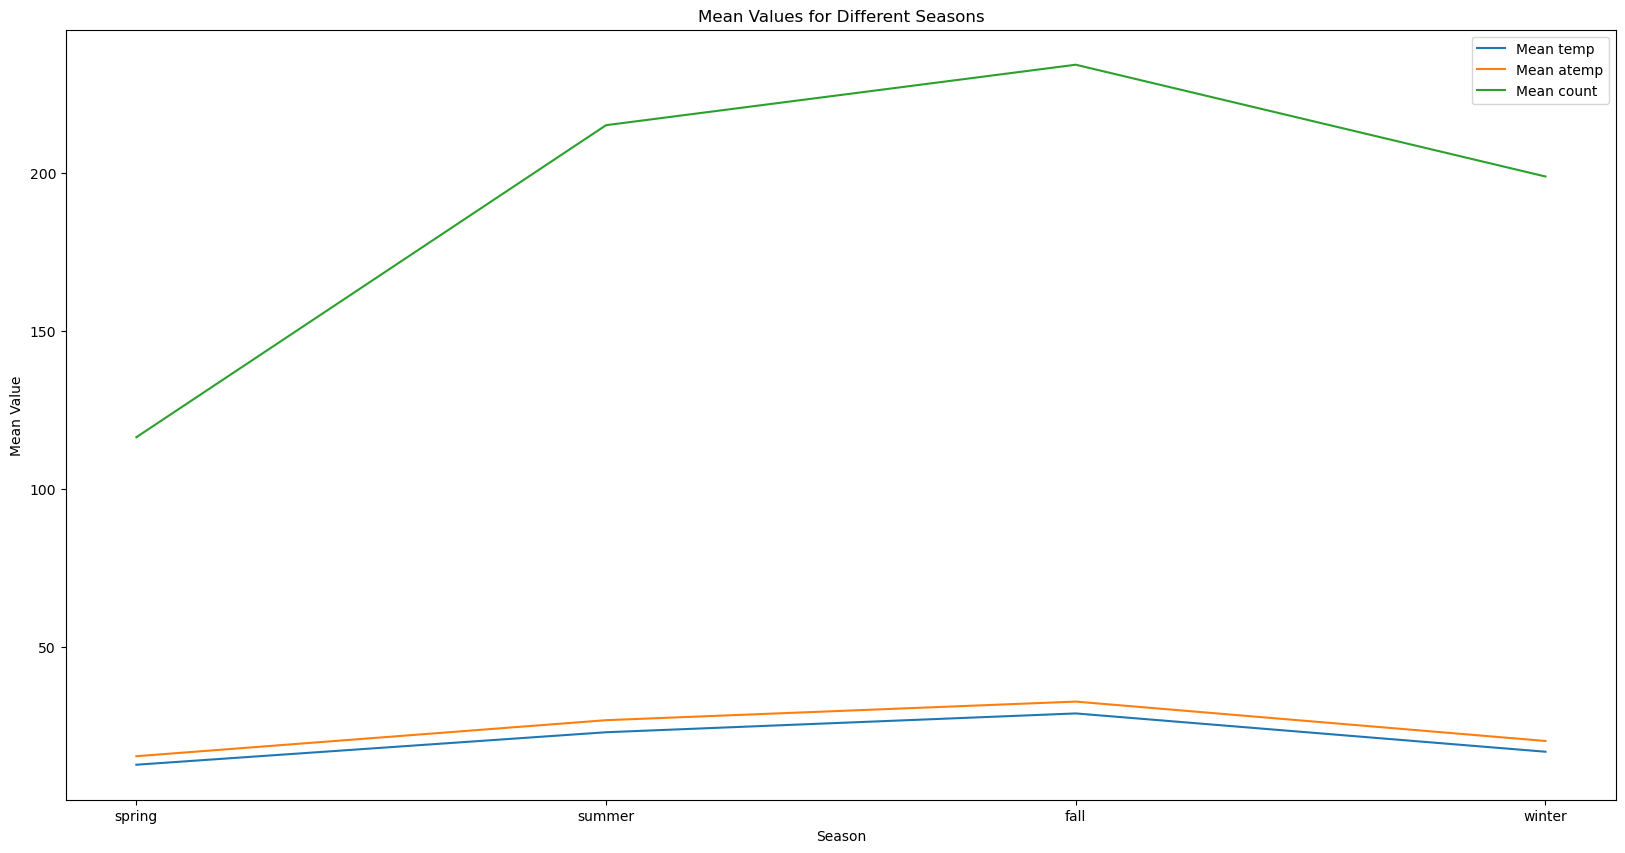

In [122]:
x = ["spring", "summer", "fall", "winter"]
y, y1, y2 = [], [], []

for i in range(1, 5):
    y.append(np.mean(df_train[df_train["season"] == i]["temp"].values.tolist()))
    y1.append(np.mean(df_train[df_train["season"] == i]["atemp"].values.tolist()))
    y2.append(np.mean(df_train[df_train["season"] == i]["count"].values.tolist()))

plt.figure(figsize=(20, 10))
plt.plot(x, y, label="Mean temp")
plt.plot(x, y1, label="Mean atemp")
plt.plot(x, y2, label="Mean count")
plt.legend()
plt.xlabel("Season")
plt.ylabel("Mean Value")
plt.title("Mean Values for Different Seasons")
plt.show()


### Let's how the count is distributed over the seasons

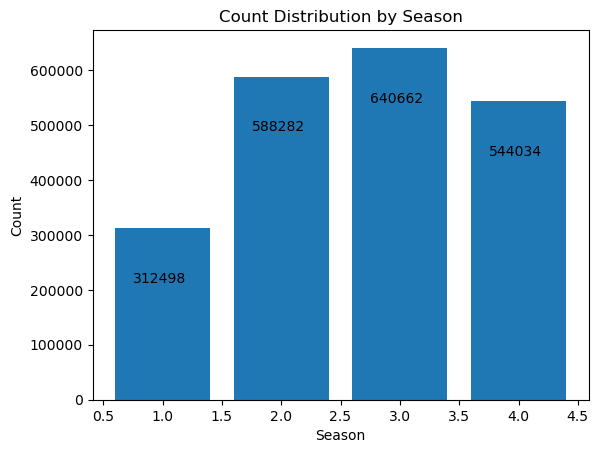

In [34]:
season_counts = df_train.groupby('season')['count'].sum()

plt.bar(season_counts.index, season_counts.values)
plt.xlabel('Season')
plt.ylabel('Count')
plt.title('Count Distribution by Season')

# Annotate the count values on the bars
for i, count in enumerate(season_counts.values):
    plt.text(i + 1.2, count- 105000 , str(count), ha='right', va='bottom', fontsize=10)

plt.show()



### Let's see how the rental is distributed over the hours of the day

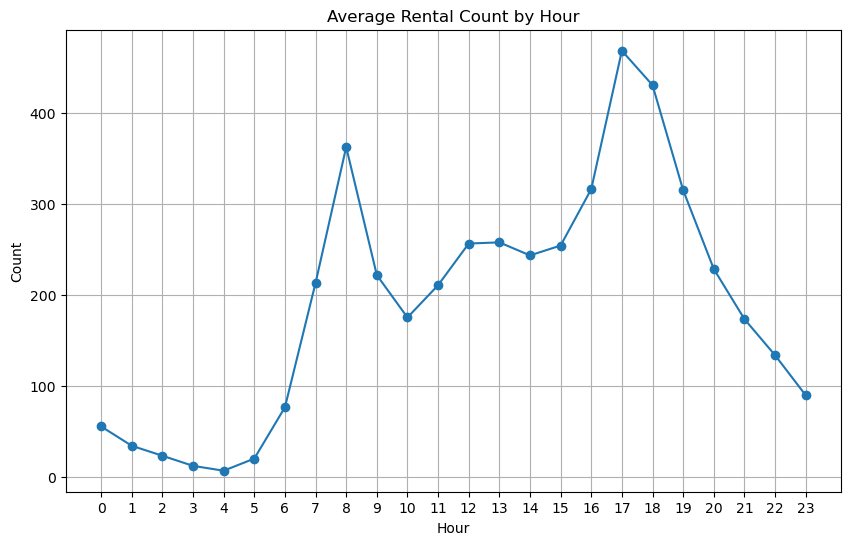

In [123]:

hourly_counts = df_train.groupby('hour')['count'].mean()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(hourly_counts.index, hourly_counts.values, marker='o', linestyle='-')
plt.xlabel('Hour')
plt.ylabel('Count')
plt.title('Average Rental Count by Hour')
plt.xticks(hourly_counts.index)
plt.grid(True)
plt.show()


### Let's see how the rental is distributed over the months of the year


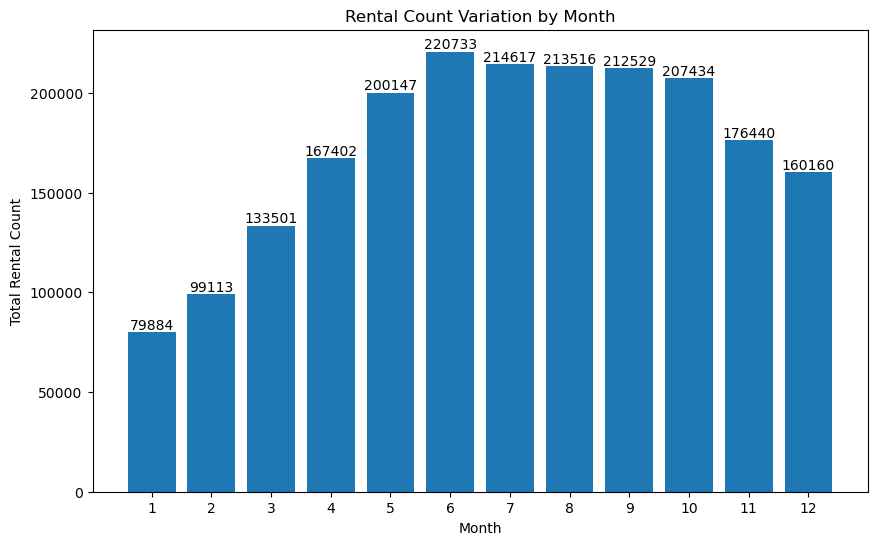

In [124]:

rental_count_per_month = df_train.groupby('month')['count'].sum()
months = rental_count_per_month.index
count = rental_count_per_month.values

plt.figure(figsize=(10, 6))
bars = plt.bar(months, count, color = "blue")
plt.bar(months, count)
plt.xlabel('Month')
plt.ylabel('Total Rental Count')
plt.title('Rental Count Variation by Month')
plt.xticks(months)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.show()


### Correlation

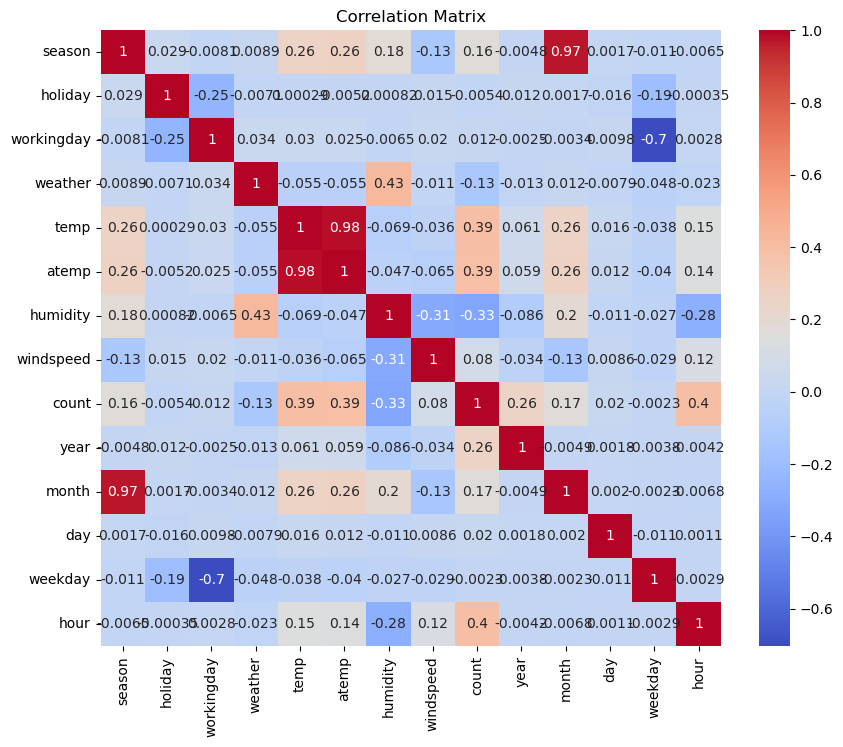

In [125]:
corr_matrix = df_train.corr()

# Plot correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

### There is a strong correlation between temp and atemp so we will drop the atemp column

In [126]:
df_train = df_train.drop('atemp',axis=1)

### Models

From the evaluation tab we know that our models are going to be evaluated with the Root Mean Squared Logarithmic Error

In [133]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier

### Split Dataset

In [70]:
# Split training dataset
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(df_train2.drop('count',axis=1),df_train2['count'],random_state=0)

In [138]:
models=[RandomForestRegressor(), AdaBoostRegressor(),BaggingRegressor(), DecisionTreeRegressor(), KNeighborsClassifier()]
model_names=['RandomForestRegressor', 'AdaBoostRegressor','BaggingRegressor', 'DecisionTreeRegressor', 'KNeighborsClassifier']
rmsle=[]
out={}
for model in range (len(models)):
    clf=models[model]
    clf.fit(x_train,y_train)
    test_pred=clf.predict(x_test)
    rmsle.append(mean_squared_log_error(test_pred,y_test, squared=False))
out={'Model':model_names,'RMSLE':rmsle}   
out

{'Model': ['RandomForestRegressor',
  'AdaBoostRegressor',
  'BaggingRegressor',
  'DecisionTreeRegressor',
  'KNeighborsClassifier'],
 'RMSLE': [0.33381565042980993,
  1.1155994204681627,
  0.3508351010501984,
  0.4277915012922327,
  1.3795907652396662]}

In [139]:
rmsle_frame=pd.DataFrame(out)
rmsle_frame

,Model,RMSLE
0,RandomForestRegressor,0.333816
1,AdaBoostRegressor,1.115599
2,BaggingRegressor,0.350835
3,DecisionTreeRegressor,0.427792
4,KNeighborsClassifier,1.379591


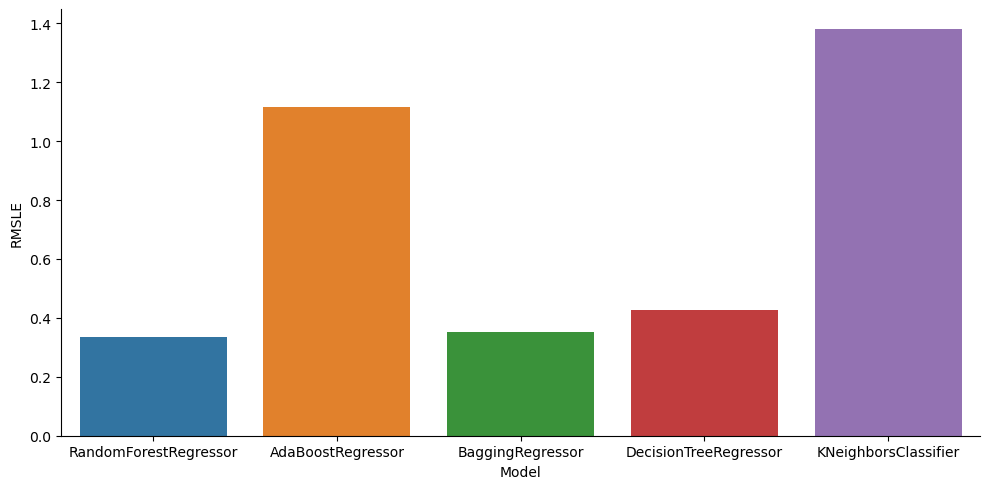

In [142]:
sn.factorplot(x='Model',y='RMSLE',data=rmsle_frame,kind='bar',size=5,aspect=2)

### Let's now tune our parameters

In [84]:
from sklearn.model_selection import GridSearchCV

In [85]:
# Random forest

params_dict={'n_estimators':[300,350,400,450,500],'n_jobs':[-1],'max_features':["auto",'sqrt','log2']}
clf_rf=GridSearchCV(estimator=RandomForestRegressor(),param_grid=params_dict,scoring='neg_mean_squared_log_error')
clf_rf.fit(x_train,y_train)
pred=clf_rf.predict(x_test)
print(mean_squared_log_error(pred,y_test, squared=False))

0.3329560677350912


In [86]:
clf_rf.best_params_


{'max_features': 'auto', 'n_estimators': 350, 'n_jobs': -1}

In [89]:
# bagging
params_dict = {
    'n_estimators': [300,350,400,450,500],
    'max_features': [0.90, 0.92, 0.95, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
}
clf = GridSearchCV(estimator=BaggingRegressor(), param_grid = params_dict, scoring='neg_mean_squared_log_error')
clf.fit(x_train, y_train)
pred=clf_rf.predict(x_test)
print(mean_squared_log_error(pred,y_test, squared=False))

KeyboardInterrupt: 